In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

import doubleml as dml

from sklearn.linear_model import LassoCV
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from doubleml import DoubleMLPLR
from doubleml.datasets import DoubleMLData
from tqdm import tqdm
from scipy import stats

from utils import make_data_list, simulate_lasso_plr

def non_orth_score(y, d, l_hat, m_hat, g_hat, smpls):
    u_hat = y - g_hat
    psi_a = -np.multiply(d, d)
    psi_b = np.multiply(d, u_hat)
    return psi_a, psi_b

# 1. Effect of Orthogonalization

In [9]:
n_rep = 2000
n_obs = 500
n_vars = 20
theta = 0.3

seed = 1312

face_colors = sns.color_palette('summer_r')
edge_colors = sns.color_palette('dark')

np.random.seed(seed)

plr_sample_CCDDHNR2018 = make_data_list(n_rep=n_rep,
                                        n_obs=n_obs,
                                        n_vars=n_vars,
                                        model_type='plr',
                                        alpha=theta)
print(f"Number of Datasets Generated: {len(plr_sample_CCDDHNR2018)}")

Number of Datasets Generated: 2000


## 1.1 Non-orthogonal Score

100%|██████████| 2000/2000 [03:13<00:00, 10.34it/s]


Text(0.5, 0, '$(\\hat{\\theta}_0 - \\theta_0)/\\hat{\\sigma}$')

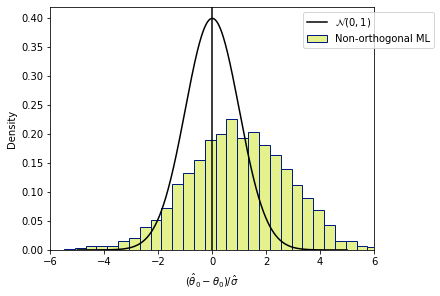

In [10]:
np.random.seed(seed)

ml_l = LassoCV()
ml_m = LassoCV()
ml_g = clone(ml_m)

theta_nonorth_scores = np.zeros(shape=(n_rep,))
se_nonorth_scores = np.zeros(shape=(n_rep,))

for i_rep in tqdm(range(n_rep)):
    (x, y, d) = plr_sample_CCDDHNR2018[i_rep]
    obj_dml_data = DoubleMLData.from_arrays(x, y, d)
    obj_plr_dml_nonorth = DoubleMLPLR(obj_dml_data,
                                      ml_l=ml_l,
                                      ml_m=ml_m,
                                      ml_g=ml_g,
                                      n_folds=2,
                                      apply_cross_fitting=False,
                                      score=non_orth_score)
    obj_plr_dml_nonorth.fit()
    this_theta = obj_plr_dml_nonorth.coef[0]
    this_se = obj_plr_dml_nonorth.se[0]
    theta_nonorth_scores[i_rep] = this_theta
    se_nonorth_scores[i_rep] = this_se

plt.figure(constrained_layout=True)

ax = sns.histplot((theta_nonorth_scores - theta)/se_nonorth_scores,
                  color=face_colors[0], edgecolor = edge_colors[0],
                  stat='density', bins=30, label='Non-orthogonal ML')


ax.axvline(0., color='k')

xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)

ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

ax.set_xlim([-6., 6.])

ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$')

## 1.2 Orthogonal Score

100%|██████████| 2000/2000 [02:10<00:00, 15.30it/s]


Text(0.5, 0, '$(\\hat{\\theta}_0 - \\theta_0)/\\hat{\\sigma}$')

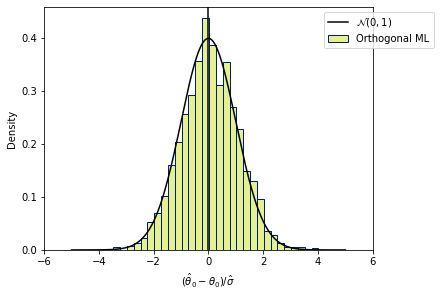

In [11]:
np.random.seed(seed)

ml_l = LassoCV()
ml_m = LassoCV()
#ml_g = clone(ml_m)

theta_orth_scores = np.zeros(shape=(n_rep,))
se_orth_scores = np.zeros(shape=(n_rep,))

for i_rep in tqdm(range(n_rep)):
    (x, y, d) = plr_sample_CCDDHNR2018[i_rep]
    obj_dml_data = DoubleMLData.from_arrays(x, y, d)
    obj_plr_dml_orth = DoubleMLPLR(obj_dml_data,
                                      ml_l=ml_l,
                                      ml_m=ml_m,
                                      #ml_g=ml_g,
                                      n_folds=2,
                                      apply_cross_fitting=False,
                                      score='partialling out')
    obj_plr_dml_orth.fit()
    this_theta = obj_plr_dml_orth.coef[0]
    this_se = obj_plr_dml_orth.se[0]
    theta_orth_scores[i_rep] = this_theta
    se_orth_scores[i_rep] = this_se

plt.figure(constrained_layout=True)

ax = sns.histplot((theta_orth_scores - theta)/se_orth_scores,
                  color=face_colors[0], edgecolor = edge_colors[0],
                  stat='density', bins=30, label='Orthogonal ML')


ax.axvline(0., color='k')

xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)

ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

ax.set_xlim([-6., 6.])

ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$')

## 1.3 Plot Results

<ipython-input-12-3a44bf912f3c>:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "face_color" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("plots/non_vs_nonorth_simulation.png",


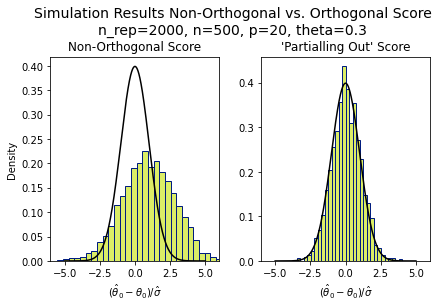

In [12]:
face_colors = sns.color_palette('summer_r')
edge_colors = sns.color_palette('dark')

fig, ax = plt.subplots(1, 2)
fig.suptitle(f"Simulation Results Non-Orthogonal vs. Orthogonal Score\nn_rep={n_rep}, n={n_obs}, p={n_vars}, theta={theta}",
             fontsize=14)
fig.tight_layout()

xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)

ax[0].set_title(f"Non-Orthogonal Score")

ax[0].hist((theta_nonorth_scores - theta)/se_nonorth_scores,
            color=face_colors[0], edgecolor = edge_colors[0],
            density=True, bins=30, label='Non-Orthogonal ML')
ax[0].plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')

ax[0].set_xlim([-6., 6.])
ax[0].set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$')
ax[0].set_ylabel('Density')

ax[1].set_title(f"'Partialling Out' Score")

ax[1].hist((theta_orth_scores - theta)/se_orth_scores,
            color=face_colors[0], edgecolor = edge_colors[0],
            density=True, bins=30, label='Orthogonal ML')
ax[1].plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')

ax[1].set_xlim([-6., 6.])
ax[1].set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$')

plt.savefig("plots/non_vs_nonorth_simulation.png", 
            face_color="white",
            bbox_inches='tight')

plt.show()

# 2. Effect of Sample Splitting

# 2.1 No Sample Splitting

100%|██████████| 250/250 [05:06<00:00,  1.23s/it]


Text(0.5, 0, '$(\\hat{\\theta}_0 - \\theta_0)/\\hat{\\sigma}$')

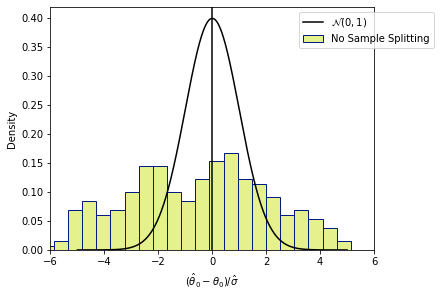

In [23]:
np.random.seed(seed)

ml_l = RandomForestRegressor()
ml_m = RandomForestRegressor()
ml_g = clone(ml_m)

n_rep = 250

theta_nosplit_scores = np.zeros(shape=(n_rep,))
se_nosplit_scores = np.zeros(shape=(n_rep,))

for i_rep in tqdm(range(n_rep)):
    (x, y, d) = plr_sample_CCDDHNR2018[i_rep]
    obj_dml_data = DoubleMLData.from_arrays(x, y, d)
    obj_plr_dml_nosplit = DoubleMLPLR(obj_dml_data,
                                      ml_l=ml_l,
                                      ml_m=ml_m,
                                      ml_g=ml_g,
                                      n_folds=1,
                                      apply_cross_fitting=False,
                                      score='IV-type')
    obj_plr_dml_nosplit.fit()
    this_theta = obj_plr_dml_nosplit.coef[0]
    this_se = obj_plr_dml_nosplit.se[0]
    theta_nosplit_scores[i_rep] = this_theta
    se_nosplit_scores[i_rep] = this_se

plt.figure(constrained_layout=True)

ax = sns.histplot((theta_nosplit_scores - theta)/se_nosplit_scores,
                  color=face_colors[0], edgecolor = edge_colors[0],
                  stat='density', bins=30, label='No Sample Splitting')


ax.axvline(0., color='k')

xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)

ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

ax.set_xlim([-6., 6.])

ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$')

# 2.2 Applied Sample Splitting

100%|██████████| 250/250 [04:53<00:00,  1.17s/it]


Text(0.5, 0, '$(\\hat{\\theta}_0 - \\theta_0)/\\hat{\\sigma}$')

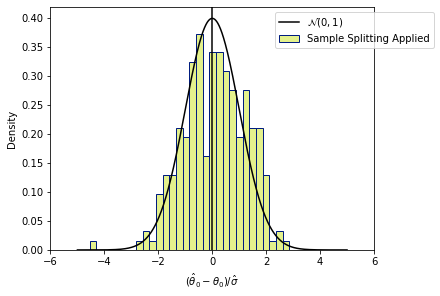

In [24]:
np.random.seed(seed)

ml_l = RandomForestRegressor()
ml_m = RandomForestRegressor()
ml_g = clone(ml_m)

n_rep = 250

theta_split_scores = np.zeros(shape=(n_rep,))
se_split_scores = np.zeros(shape=(n_rep,))

for i_rep in tqdm(range(n_rep)):
    (x, y, d) = plr_sample_CCDDHNR2018[i_rep]
    obj_dml_data = DoubleMLData.from_arrays(x, y, d)
    obj_plr_dml_split = DoubleMLPLR(obj_dml_data,
                                      ml_l=ml_l,
                                      ml_m=ml_m,
                                      ml_g=ml_g,
                                      n_folds=2,
                                      apply_cross_fitting=True,
                                      score='IV-type')
    obj_plr_dml_split.fit()
    this_theta = obj_plr_dml_split.coef[0]
    this_se = obj_plr_dml_split.se[0]
    theta_split_scores[i_rep] = this_theta
    se_split_scores[i_rep] = this_se

plt.figure(constrained_layout=True)

ax = sns.histplot((theta_split_scores - theta)/se_split_scores,
                  color=face_colors[0], edgecolor = edge_colors[0],
                  stat='density', bins=30, label='Sample Splitting Applied')


ax.axvline(0., color='k')

xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)

ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

ax.set_xlim([-6., 6.])

ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$')

# 2.3 Plot Results

<ipython-input-25-8995bda57ec3>:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "face_color" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("plots/nosplit_vs_split_simulation.png",


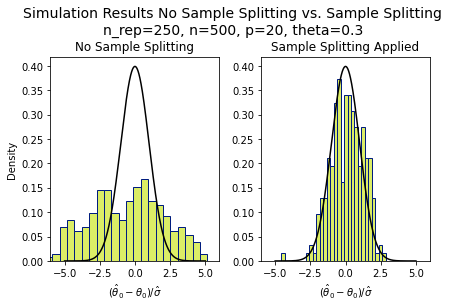

In [25]:
face_colors = sns.color_palette('summer_r')
edge_colors = sns.color_palette('dark')

fig, ax = plt.subplots(1, 2)
fig.suptitle(f"Simulation Results No Sample Splitting vs. Sample Splitting\nn_rep={n_rep}, n={n_obs}, p={n_vars}, theta={theta}",
             fontsize=14)
fig.tight_layout()

xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)

ax[0].set_title(f"No Sample Splitting")

ax[0].hist((theta_nosplit_scores - theta)/se_nosplit_scores,
            color=face_colors[0], edgecolor = edge_colors[0],
            density=True, bins=30, label='Non-Orthogonal ML')
ax[0].plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')

ax[0].set_xlim([-6., 6.])
ax[0].set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$')
ax[0].set_ylabel('Density')

ax[1].set_title(f"Sample Splitting Applied")

ax[1].hist((theta_split_scores - theta)/se_split_scores,
            color=face_colors[0], edgecolor = edge_colors[0],
            density=True, bins=30, label='Orthogonal ML')
ax[1].plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')

ax[1].set_xlim([-6., 6.])
ax[1].set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$')

plt.savefig("plots/nosplit_vs_split_simulation.png", 
            face_color="white",
            bbox_inches='tight')

plt.show()